In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

In [2]:
# !nrnivmodl mod/

In [3]:
import neuron
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

soma = neuron.h.Section(name='soma')
soma.L = 40
soma.diam = 40

time = neuron.h.Vector()
voltage = neuron.h.Vector()
time.record(neuron.h._ref_t)
voltage.record(soma(.5)._ref_v);

In [4]:
neuron.h.tstop = 100
neuron.h.dt = 0.025

In [5]:
def plot_tv(time_array, voltage_array, show=True, label=None, constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()

In [6]:
iclamp = neuron.h.IClamp(.5, sec=soma)
iclamp.amp = 0.1 # nA
iclamp.delay = 10 # ms
iclamp.dur = 50 # ms

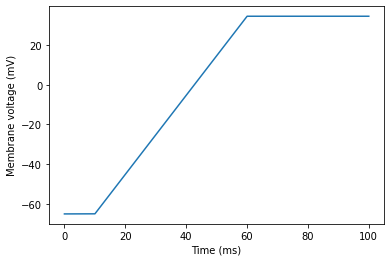

In [7]:
neuron.h.run()

plot_tv(time, voltage)

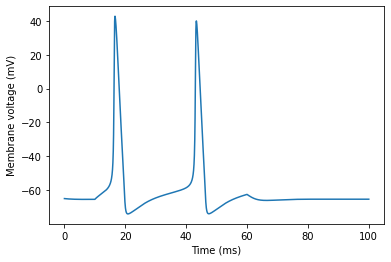

In [8]:
soma.insert('hh');
soma.gl_hh = 5e-4 # Leak conductance, S/cm^2
el = soma.el_hh = -65 # Reversal potential leak current, mV
soma.gkbar_hh = 0.01 # in S/cm^2
soma.gnabar_hh = 0.1

neuron.h.tstop = 100

neuron.h.run()

plot_tv(time, voltage)

In [9]:
dend = neuron.h.Section(name='dend')

dend.connect(soma)

dend.L = 400 # micron
dend.diam = 2.0 # micron
dend.nseg = 9 # number of segments in the dendritic section

dend.insert('hh')
dend.el_hh = -65 # Reversal potential leak current, mV
dend.gl_hh = 5e-4 # Leak conductance, S/cm^2

dend.gkbar_hh = 0.0
dend.gnabar_hh = 0.0

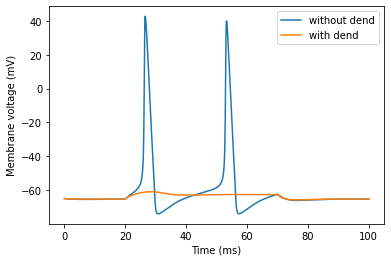

In [10]:
import matplotlib.pyplot as plt
import numpy

for with_dend in [False, True]:
    
    iclamp.amp = 0.1 # nA
    iclamp.delay = 20 # ms
    iclamp.dur = 50 # ms
    
    if with_dend:
        dend.connect(soma)
    else:
        neuron.h.disconnect(sec=dend) # disconnect dend for now
        
    neuron.h.run()

    # Convert the NEURON vectors to numpy arrays
    time_py = time.to_python()
    voltage_py = voltage.to_python()

    plot_tv(time_py, voltage_py, show=False, label='with dend' if with_dend else 'without dend')

plt.legend()
plt.show()

## Synapses

In [11]:
expsyn = neuron.h.Exp2Syn(.5, sec=dend) # We add a synapse to the middle (.5) of the dendrite
expsyn.tau1 = 0.2
expsyn.tau2 = 5.0

To stimulate the synapse we create a NetStim object. It basically plays the role of a presynaptic cell. The attributes of this object specify how many times we want to stimulate, with which interval and when we want to start. The noise attribute determines the stochasticity of the process, 0 means completely regular firing.

In [12]:
netstim = neuron.h.NetStim()
netstim.interval = 20
netstim.number = 5
netstim.start = 20
netstim.noise = 0

This NetStim needs to be connected to the cell. A NetCon object acts as a connector between a presynaptic and postsynaptic cell.

In [13]:
netcon = neuron.h.NetCon(netstim, expsyn)
netcon.weight[0] = 0.001

And now we can simulate:

In [14]:
time = neuron.h.Vector()
voltage = neuron.h.Vector()

time.record(neuron.h._ref_t)
voltage.record(soma(.5)._ref_v);

iclamp.amp = 0
neuron.h.tstop = 200

soma_pre = neuron.h.Section(name='soma')
soma_pre.L = 40
soma_pre.diam = 40
soma_pre.insert('hh')

iclamp_pre = neuron.h.IClamp(.5, sec=soma_pre)
iclamp_pre.amp = 0.35 # nA
iclamp_pre.delay = 10 # ms
iclamp_pre.dur = 500 # ms

time_pre = neuron.h.Vector()
voltage_pre = neuron.h.Vector()

time_pre.record(neuron.h._ref_t)
voltage_pre.record(soma_pre(.5)._ref_v);

expsyn.tau1 = 0.2
expsyn.tau2 = 5.0
netcon_pre = neuron.h.NetCon(soma_pre(.5)._ref_v, expsyn, sec=soma_pre)
netcon_pre.weight[0] = 0.001

neuron.h.run()

0.0

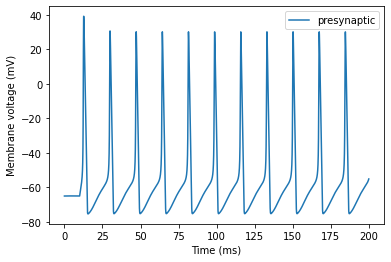

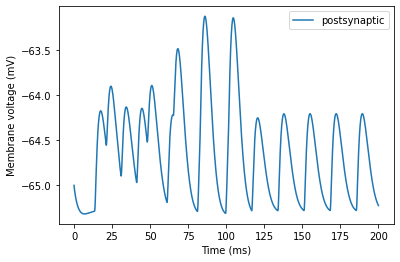

In [15]:
plot_tv(time_pre, voltage_pre, show=False, label='presynaptic')
plt.legend()
plt.show()
plot_tv(time, voltage, show=False, label='postsynaptic')
plt.legend()
plt.show()

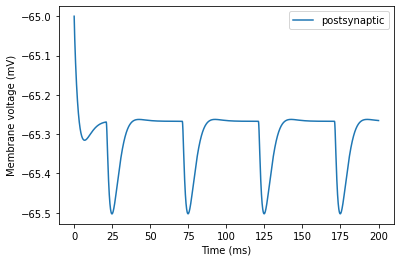

In [16]:
# del netcon_pre
netstim = neuron.h.NetStim()
netstim.interval = 50
netstim.number = 5
netstim.start = 20
netstim.noise = 0

expsyn = neuron.h.Exp2Syn(.5, sec=dend) # We add a synapse to the middle (.5) of the dendrite
expsyn.tau1 = 0.2
expsyn.tau2 = 5.0
expsyn.e = -80

netcon = neuron.h.NetCon(netstim, expsyn)
netcon.weight[0] = 0.001

neuron.h.tstop = 200
neuron.h.run()

plot_tv(time, voltage, show=False, label='postsynaptic')
plt.legend()
plt.show()

### ProbAMPANMDA_EMS


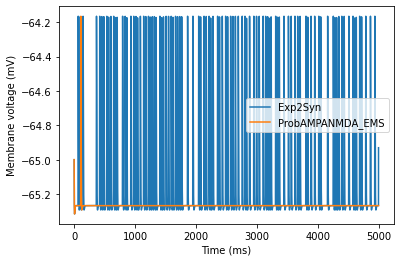

In [18]:
pre = 'Exp2Syn'
if pre == 'Exp2Syn':
    netstim = neuron.h.NetStim()
    netstim.interval = 50
    netstim.number = 500
    netstim.start = 50
    netstim.noise = 0.5

    expsyn = neuron.h.Exp2Syn(.5, sec=dend) # We add a synapse to the middle (.5) of the dendrite
    expsyn.tau1 = 0.2
    expsyn.tau2 = 5.0
    expsyn.e = 0

    netcon = neuron.h.NetCon(netstim, expsyn)
    netcon.weight[0] = 0.001

    neuron.h.tstop = 5000
    neuron.h.run()

    plot_tv(time, voltage, show=False, label='Exp2Syn')
    plt.legend()
    del netcon

pre = 'ProbAMPANMDA_EMS'   
if pre == 'ProbAMPANMDA_EMS':

    netstim = neuron.h.NetStim()
    netstim.interval = 50
    netstim.number = 5000
    netstim.start = 50
    netstim.noise = 0.5

    probsyn = neuron.h.ProbAMPANMDA_EMS(dend(0.5))
    probsyn.tau_d_AMPA = 5.0
    probsyn.tau_r_AMPA = 0.2   
    probsyn.tau_d_NMDA = 260.9
    probsyn.tau_r_NMDA  = 3.5

    probsyn.Use = 1.0    
    probsyn.Fac = 100.0   
    probsyn.Dep = 10.0    

    probsyn.NMDA_ratio = 0

    netcon = neuron.h.NetCon(netstim, probsyn)
    netcon.weight[0] = 1.0

    neuron.h.tstop = 5000
    neuron.h.run()

    plot_tv(time, voltage, show=False, label='ProbAMPANMDA_EMS')
    plt.legend()
    del netcon

plt.show()